# 가장 좋은 결과를 낼 수 있는 feature항목 추출

## 모든 feature를 사용한 결과와, 선택 추출된 feature만 사용한 결과 정확도에 차이가 남
#### logistic 회귀 이용하여 coef_ 항목에서 영향력이 높은 feature를 선택. 최적의 갯수 선택

### 데이터 준비하기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# standardscaler 저장 필요. 
# predict하기 위한 데이터 전처리 방법.

In [12]:
data_new = data[data_columns]
# target = df.iloc[:, -2]  # logistic regression에서 생성된 target을 그대로 사용

In [13]:
train_input, test_input, train_target, test_target = train_test_split(data_new, target, random_state=42, test_size=0.2, stratify=target)

In [14]:
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

In [15]:
value = []
for iter in range(5, 50, 1):
    sc = SGDClassifier(loss='log', max_iter=iter, random_state=42)
#     sc = SGDClassifier(max_iter=iter, random_state=42)
    scores = cross_validate(sc,
                            X=train_scaled, y=train_target,
                            n_jobs=-1)
#     print(scores['test_score'].mean())
    value.append(scores['test_score'].mean())

In [16]:
print("max", max(value))

max 0.7504615384615384


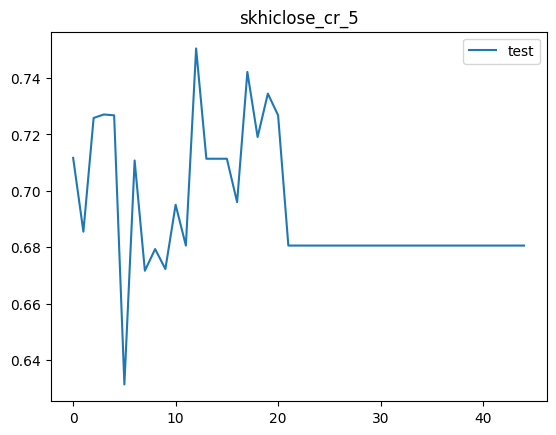

In [17]:
plt.plot(value, label = 'test')
plt.title(plt_title+plt_title2)
plt.legend()

### 인공신경망

In [18]:
def model_fn(inp_num, a_layer=None):
    model = Sequential()
    model.add(Dense(12, activation='relu', input_shape=(inp_num,)))
#     model.add(Dropout(0.3))
    model.add(Dense(6, activation='relu'))
#     model.add(Dropout(0.3))
    if a_layer:
        model.add(a_layer)
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [19]:
adam_custom = tf.keras.optimizers.Adam(
    learning_rate=0.0005, # default  0.001 , best fit 0.0001 for skhinix
    beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,  # default
    weight_decay=None, clipnorm=None, clipvalue=None, global_clipnorm=None, use_ema=False, ema_momentum=0.99,
    ema_overwrite_frequency=None, jit_compile=True, name='Adam' )

In [20]:
# model = model_fn(10, len(data_new.columns), 2, Dropout(0.3))
try :
    model = None
    print("delete del")
except:
    pass
model = model_fn(len(data_new.columns))
# model.compile(optimizer='adam', loss='binary_crossentropy', 
#               metrics=['accuracy'])
model.compile(optimizer=adam_custom, loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()

delete del
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                84        
                                                                 
 dense_1 (Dense)             (None, 6)                 78        
                                                                 
 dense_2 (Dense)             (None, 1)                 7         
                                                                 
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________


In [21]:
# checkpoint_cb = ModelCheckpoint('best_model.h5', save_best_only=True)
today = datetime.date.today().isoformat()
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath='best_model/best_model_{epoch:02d}-{val_loss:.2f}-{val_accuracy:.2f}.h5', \
     save_best_only=True)
# checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath='best_model/skhinix_model.h5', \
#                                                 monitor='val_accuracy', mode='max', save_best_only=True)
# checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath='best_model/skhinix_model.h5', save_best_only=True)
# earlystopping_cb = keras.callbacks.EarlyStopping(patience=100, monitor='val_accuracy', mode='max', restore_best_weights=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=100, monitor='val_loss', mode='min', restore_best_weights=True)
# earlystopping_cb = keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)

In [22]:
history = model.fit(train_scaled, train_target, epochs=10000, verbose=0,
                    callbacks=[checkpoint_cb, earlystopping_cb],
                    validation_data=(test_scaled, test_target))

# loss 가 최저로 내려가지 않거나 큰 상태에서 머무르면 adam (optimizer)의 learning rate를 줄이면서 loss가 작아지는지 시도해 볼 것

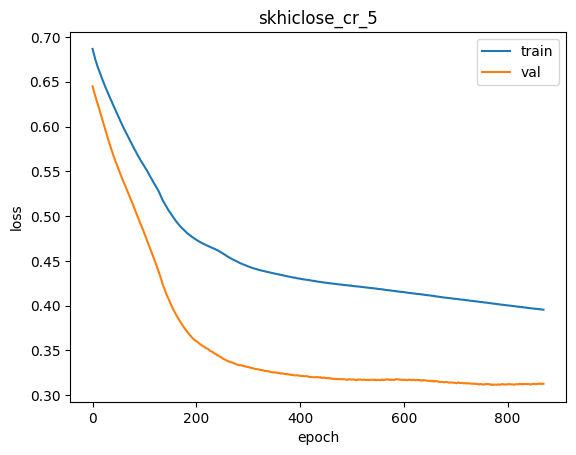

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.title(plt_title+plt_title2)
plt.show()

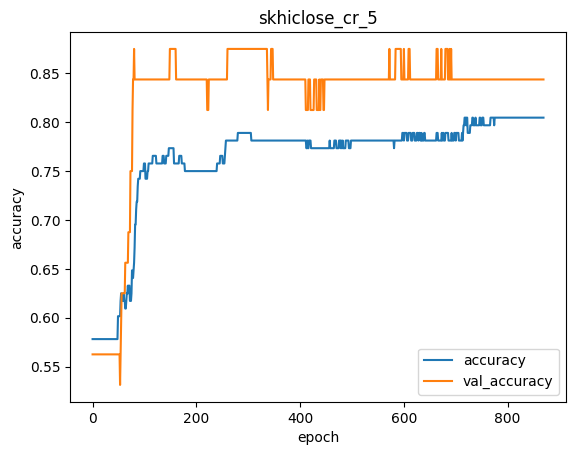

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.title(plt_title+plt_title2)
plt.show()

In [25]:
# save feature columns
directory = f'best_model_{stock_name}/'
list_to_pickle(directory+f'data_columns_{stock_name}.pkl', data_columns)

In [24]:
earlystopping_cb.stopped_epoch

379

In [25]:
model.evaluate(test_scaled, test_target)

1/1 [==============================] - 0s 18ms/step - loss: 0.3033 - accuracy: 0.9062


[0.3032555878162384, 0.90625]

In [26]:
model_val = load_model('best_model/best_model_1736-0.26-0.88.h5')
model_val.evaluate(test_scaled, test_target)

OSError: No file or directory found at best_model/best_model_1736-0.26-0.88.h5

In [27]:
y_predict = model.predict(np.array(test_scaled))

1/1 [==============================] - 0s 61ms/step


In [28]:
y_predict_list = [1 if i > 0.5 else 0 for i in y_predict[:, 0]]

In [29]:
compare = [ [x, y] for x, y in zip(test_target, y_predict)]
# compare = [ [x, y] for x, y in zip(test_target, y_predict_list)]
compare # 실제값. 예측값

[[1, array([0.5367629], dtype=float32)],
 [1, array([0.814933], dtype=float32)],
 [0, array([0.0426366], dtype=float32)],
 [0, array([0.12799788], dtype=float32)],
 [0, array([0.01986086], dtype=float32)],
 [1, array([0.7466521], dtype=float32)],
 [1, array([0.8114403], dtype=float32)],
 [1, array([0.6325327], dtype=float32)],
 [0, array([0.2450234], dtype=float32)],
 [0, array([0.1403952], dtype=float32)],
 [1, array([0.75971687], dtype=float32)],
 [0, array([0.03277837], dtype=float32)],
 [0, array([0.05411454], dtype=float32)],
 [1, array([0.80162627], dtype=float32)],
 [0, array([0.72625345], dtype=float32)],
 [0, array([0.4433458], dtype=float32)],
 [1, array([0.69703156], dtype=float32)],
 [0, array([0.03167004], dtype=float32)],
 [1, array([0.47026014], dtype=float32)],
 [1, array([0.7559448], dtype=float32)],
 [0, array([0.18884565], dtype=float32)],
 [1, array([0.7664117], dtype=float32)],
 [0, array([0.11209238], dtype=float32)],
 [0, array([0.16173203], dtype=float32)],
 [1,

In [30]:
from sklearn.metrics import precision_score, recall_score
# 정밀도 : 양성으로 예측된 것(TP+FP) 중 얼마나 많은 샘플이 진짜 양성(TP)인지 측정
precision_score(test_target, y_predict_list)  # 정밀도, 입력값의 순서 중요힘. (실제값, 예측값)

0.9230769230769231

In [31]:
# 재현율 : 전체 양성 샘플(TP+FN) 중에서 얼마나 많은 샘플이 진짜 양성(TP)인지 측정
recall_score(test_target, y_predict_list)  # 재현율, 입력값의 순서 중요힘. (실제값, 예측값)

0.8571428571428571

In [32]:
from sklearn.metrics import f1_score

f1_score(test_target, y_predict_list)

0.888888888888889

In [33]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_target, y_predict_list)

array([[17,  1],
       [ 2, 12]], dtype=int64)

In [34]:
from sklearn.metrics import roc_auc_score

roc_auc_score(test_target, y_predict_list)

0.9007936507936508

1. 정밀도, f1-score, 
2. confusion matrix ((1,1), (2,2), 두개가 큰 비중이면 good, (1,2)은 틀린것을 맞다라고 구분, (2,1)은 맞는 것을 틀린 것이다 라고 결정하는 항목) 따라서
    (2,2) -> (1,2) -> (1,1)로 확인하고. <br>
    (1,2)가 크면 모델 제외 (정밀도(precision = TP / (TP + FP) )가 높아야 함. 낮으면 손해를 보게 됨.), <br>
    재현율(Recall = TP / (TP + FN) ) 은 손해를 끼치지는 않음.
    
<img src="https://raw.githubusercontent.com/fasthill/My-gist/main/data/picture/confusion_matrix.png" width="800"/> <br>

In [ ]:
for innum in range(30):
    aa = np.array([test_scaled[innum]])
    y_predict = model.predict(aa)
#     print("predict: {},  target_value: {}".format(y_predict, test_target[innum]))

In [ ]:
### ROC 확인해 봐야 함. 정확도, 정밀도 등

In [ ]:
'''
model.save('my_model.h5')
model_new = load_model('my_model.h5')
model_new.evaluate(test_scaled, test_target)
'''

수수료: 주식거래수수료 0.015%. 유관기관수수료 0.0036%, 증권거래세 0.08, 농어촌 특별세 0.15%
수수료 : (0.015+0.0036 ) * 2 (사고팔때), 증권거래세 : 0.08 + 0.15 (팔때)
전체 지출 금액율: 0.2672%